<a href="https://colab.research.google.com/github/tusker4/Sesac_Saltlux_DeepLearning/blob/main/4_NLP_%EC%9B%8C%EB%93%9C%EA%B8%B0%EB%B0%98_seq2seq_%EC%9D%B8%EC%BD%94%EB%8D%94_%EB%94%94%EC%BD%94%EB%8D%94_%EA%B8%B0%EA%B3%84%EB%B2%88%EC%97%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 개요
- 시퀀스-to-시퀀스(Sequence-to-Sequence)
- 인코더 + 디코더 구조
- 입력된 시퀀스로부터 다른 도메인의 시퀀스를 출력하는 다양한 분야에 적용되는 베이스 모델
  - 실제는 더 상위모델(이후 개발된) 사용

# 적용분야
- 챗봇
  - 입력 시퀀스 : 질문
  - 출력 시퀀스 : 대답(답변)
- 기계번역
  - 입력 시퀀스 : 입력문장(특정 국가언어)
  - 출력 시퀀스 : 번역문장(특정 국가언어)
- 내용요약
  - 입력 시퀀스 : 원문
  - 출력 시퀀스 : 요약문
- STT
  - 입력 시퀀스 : speech(Audio)
  - 출력 시퀀스 : Text
- 특징구조
  - many to many



# 구조

## 인코더

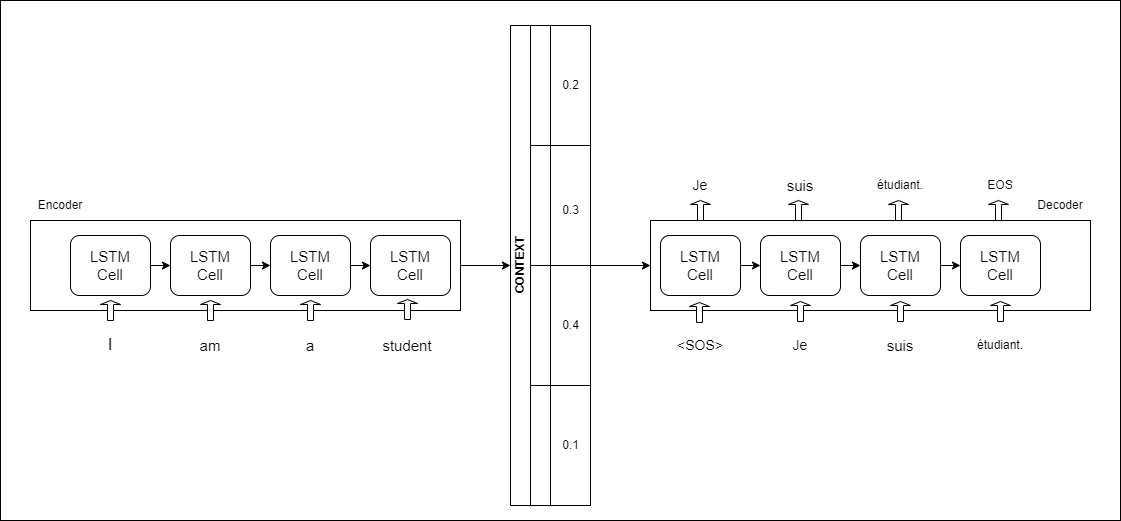

In [92]:
from IPython.display import Image
'''
- 컨텍스트 백터(인코더->디코더로 가는 입력백터) -> 그림은 편의상 4차원표현, 실제는 더 크다(수백개)
- LSTM 자리에는 RNN, GRU 적용 가능
- 인코더
    - 입력문장->토큰으로 쪼개지고 => 토큰은 각각의 LSTM 셀의 각 시점에 입력이됨(순서대로 입력)
    - 인코더의 마지막 LSTM셀에서 은닉 상태를 디코더의 첫번째 LSTM 셀에 넘긴다
        - 이때 넘어가는 데이터 : 컨텍스트 백터
    - 컨테스트 백터는 디코더 LSTM의 첫번째 은닉 상태 입력값이 된다.
- 디코더
  - 초기 입력 문장의 시작을 알리는 값(설정)  <SOS> 혹은 특정설정값(\t) 지정해서 입력
  - 다음에 등장할 확률이 가장 높은 단어 예측 -> Je 출력 -> 두번째 시점에 입력 사용
  - 다음에 등장할 확률이 가장 높은 단어 예측 -> suis 출력 -> 세번째 시점에 입력 사용
  - 반복 ---> <EOS> 혹은 특정설정값(\n)이 나올때까지 반복

'''
Image('/content/drive/MyDrive/머신러닝(솔트룩스)/딥 러닝/딥러닝_NLP/rnn/시퀀스투시퀀스.png', width=800)

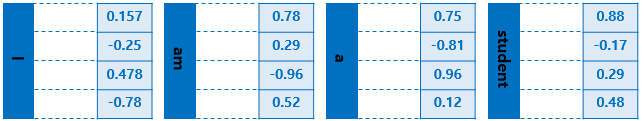

In [93]:
Image('/content/drive/MyDrive/머신러닝(솔트룩스)/딥 러닝/딥러닝_NLP/rnn/임베딩백터.png')
# 새로운 입력, (장기기억선, 은닉상태값)이 반응한 결과
# 계속해서 컨텍스트 벡터는 값이 변화되서 진행됨

## 디코더

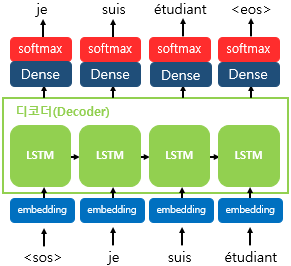

In [94]:
Image('/content/drive/MyDrive/머신러닝(솔트룩스)/딥 러닝/딥러닝_NLP/rnn/디코더.png')

- 입력
  - 컨텍스트 벡터(= 인코더의 마지막시점의 상태(은닉, 장기기억선))
  - <sos> 문자예측을 시작하라는 표식
- 출력
  - 첫번째 토큰(혹은 단어)를 예측(최고 확률)
- 반복과정
  - 상태(은닉, 장기기억선) + 새로운입력벡터(이전 시점에서 예측값 단어)-> 예측 -> 반복....
  - <EOS>
    - 예측이 끝났다는 신호 <EOS> 가 예측될때까지 반복

## 훈련방식
- 훈련, 테스트가 서로 다른 공정을 따른다
- 훈련
  - 입력
    - 인코더 입력 : 컨텍스트 벡터
    - 디코더 입력 : <SOS> je suis etudiant
  - 정답
    - je suis etudiant <EOS>
  - **교사 강요(teacher forcing) 훈련법**
    - RNN(혹은 LSTM)의 모든 시점에 대해서 이전시점의 예측값 대시 실제 값을 입력으로 주는 방식
    - 시퀀스로 연결되어 있다보니, 이전 시점의 예측이 틀리면 연쇄적으로 모든 이후시점에 영향을 미친다. 학습 시간이 기하급수적으로 상승문제가 발생

# 데이터

- 문장 페이 데이터를 이용하여 학습
    - https://www.manythings.org/anki/
    - 영어(미국식)<->프랑스어 페이로 실습

# 데이터 획득

In [95]:
import pandas as pd
import urllib3
import zipfile
import shutil
import os
import requests

In [96]:
# https://www.manythings.org/anki/kor-eng.zip 에 직접 다운로드
# User-Agent를 더미로 넣어서 정상 진입으로 인식
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
url = 'https://www.manythings.org/anki/fra-eng.zip'
response = requests.get(url, headers=headers, stream=True)
if response.status_code == 200:
  with open('fra-eng.zip', 'wb') as f:
    for chunk in response.iter_content(chunk_size=1024*8):
      # 대용량 파일 다운로드 => 특정 크기로 나눠서 스트리밍을 다운받아서 파일을 생성
      f.write(chunk)
  print('정상 응답 및 다운로드 완료')
else:
  print('다운로드 에러', response.status_code)
  # 다운로드 에러 406 => 비정상적인 루트로 진입 엑서스 => headers 조정


정상 응답 및 다운로드 완료


In [97]:
# 압축해제
with zipfile.ZipFile('fra-eng.zip', 'r') as f:
  f.extractall(os.getcwd())

# 데이터 전처리

In [98]:
fr_df = pd.read_csv('/content/fra.txt',sep='\t', names=['en', 'fr', 'etc'])
fr_df.head(2)

,en,fr,etc
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [99]:
# 데이터개수 : 227,815
fr_df.shape

(227815, 3)

In [100]:
del fr_df['etc']


In [101]:
fr_df.shape

(227815, 2)

In [102]:
# 학습시간 고려하여 데이터 샘플수 줄임
# 단문 번역을 목표로 진행 -> 앞에서부터 추출
fr_df_6 = fr_df[:60000]
fr_df_6.sample(5)

,en,fr
17368,There's no cure.,Il n'y a pas de remède.
15435,I have to think.,Je dois réfléchir.
48494,I knew Tom would win.,Je savais que Tom gagnerait.
35466,Now is your chance.,C'est l'occasion ou jamais.
5430,I was framed.,On m'a tendu un piège.


In [103]:
fr_df_6.shape

(60000, 2)

In [104]:
# 교사 강요 및 디코더의 예측을 시잓하거나 끝나게 하는 표식 추가
fr_df_6.fr = fr_df_6.fr.apply( lambda x: f'\t {x} \n')
fr_df_6.sample(5)

<ipython-input-104-a83ca81dc88c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fr_df_6.fr = fr_df_6.fr.apply( lambda x: f'\t {x} \n')


,en,fr
11825,I'm a good boy.,\t Je suis un bon garçon. \n
40333,I can't help myself.,\t C'est plus fort que moi. \n
57154,I really miss you all.,\t Vous me manquez vraiment toutes. \n
31075,You are in my way.,\t Tu te trouves en travers de mon chemin. \n
32304,Empty your pockets.,\t Videz vos poches. \n


# 문자 집합구성


In [105]:
# 사전화
en_vocab = set( ch for sentence in fr_df_6.en for ch in sentence)
fr_vocab = set( ch for sentence in fr_df_6.fr for ch in sentence )

len(en_vocab), len(fr_vocab)

(79, 103)

In [106]:
# 사전의 크기 => 단어수 + 1 해서 처리
en_vocab_size = len(en_vocab) + 1
fr_vocab_size = len(fr_vocab) + 1


In [107]:
# 사전 정렬
en_vocab = list(en_vocab)
en_vocab.sort()
fr_vocab = list(fr_vocab)
fr_vocab.sort()


In [108]:
fr_vocab

['\t',
 '\n',
 ' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '\xa0',
 '«',
 '»',
 'À',
 'Ç',
 'É',
 'Ê',
 'Ô',
 'à',
 'â',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'î',
 'ï',
 'ô',
 'ù',
 'û',
 'œ',
 '\u2009',
 '‘',
 '’',
 '\u202f',
 '‽']

In [109]:
# 문자 -> 숫자부여, 대칭표
# 영어
en_to_index =  dict( [ (ch, idx) for idx, ch in enumerate(en_vocab)] )
# 프랑스어
fr_to_index =  dict( [ (ch, idx) for idx, ch in enumerate(fr_vocab)] )
print(en_to_index)

{' ': 0, '!': 1, '"': 2, '$': 3, '%': 4, '&': 5, "'": 6, ',': 7, '-': 8, '.': 9, '/': 10, '0': 11, '1': 12, '2': 13, '3': 14, '4': 15, '5': 16, '6': 17, '7': 18, '8': 19, '9': 20, ':': 21, '?': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 32, 'K': 33, 'L': 34, 'M': 35, 'N': 36, 'O': 37, 'P': 38, 'Q': 39, 'R': 40, 'S': 41, 'T': 42, 'U': 43, 'V': 44, 'W': 45, 'X': 46, 'Y': 47, 'Z': 48, 'a': 49, 'b': 50, 'c': 51, 'd': 52, 'e': 53, 'f': 54, 'g': 55, 'h': 56, 'i': 57, 'j': 58, 'k': 59, 'l': 60, 'm': 61, 'n': 62, 'o': 63, 'p': 64, 'q': 65, 'r': 66, 's': 67, 't': 68, 'u': 69, 'v': 70, 'w': 71, 'x': 72, 'y': 73, 'z': 74, 'é': 75, 'ï': 76, '’': 77, '€': 78}


## 인코더 input 데이터 생성
- 벡터화


In [110]:
encoder_input = list()

# 문장을 하나씩 출력
for sent in fr_df_6.en:
  vec = list()
  # 문장에서 문자를 추출
  for ch in sent:
    # 문자 -> 수치 -> 리스트에 추가
    vec.append(en_to_index[ch])
  # 백터화된 문장을 리스트에 추가
  encoder_input.append(vec)

print(encoder_input[:12])

[[29, 63, 9], [29, 63, 9], [29, 63, 9], [29, 63, 9], [30, 57, 9], [30, 57, 9], [40, 69, 62, 1], [40, 69, 62, 1], [40, 69, 62, 1], [40, 69, 62, 1], [40, 69, 62, 1], [40, 69, 62, 1]]


## 디코더 input 데이터 생성
- \t 문장 \n => 백터화

In [111]:
decoder_input = list()

for sent in fr_df_6.fr:
  vec = list()
  for ch in sent:
    vec.append(fr_to_index[ch])
  decoder_input.append(vec)

print(decoder_input[:3])
print(decoder_input[-3:])

[[0, 2, 47, 51, 2, 3, 2, 1], [0, 2, 38, 51, 68, 53, 58, 55, 13, 2, 1], [0, 2, 30, 64, 2, 68, 65, 71, 70, 55, 2, 3, 2, 1]]
[[0, 2, 28, 55, 69, 2, 62, 59, 72, 68, 55, 69, 2, 69, 65, 64, 70, 2, 85, 2, 45, 65, 63, 13, 2, 1], [0, 2, 28, 55, 69, 2, 62, 59, 72, 68, 55, 69, 2, 69, 65, 64, 70, 2, 62, 65, 71, 68, 54, 69, 13, 2, 1], [0, 2, 28, 55, 69, 2, 52, 65, 92, 70, 55, 69, 2, 69, 65, 64, 70, 2, 62, 65, 71, 68, 54, 55, 69, 13, 2, 1]]


## 디코더 input 실제값 생성
- 문장 \n => 백터화
- 혹은 \t 를 제거


In [112]:
# 깊은 카피 진행 -> 모든 벡터에 맨앞자리만 삭제
import copy

decoder_target = list()
copy_df = copy.deepcopy(decoder_input)
for vec in copy_df:
  # `\t`:  제거해서 문장은 글자부터 나오겠금
  decoder_target.append(vec[2:])

print(decoder_target[:3] )
print(decoder_target[-3:])


[[47, 51, 2, 3, 2, 1], [38, 51, 68, 53, 58, 55, 13, 2, 1], [30, 64, 2, 68, 65, 71, 70, 55, 2, 3, 2, 1]]
[[28, 55, 69, 2, 62, 59, 72, 68, 55, 69, 2, 69, 65, 64, 70, 2, 85, 2, 45, 65, 63, 13, 2, 1], [28, 55, 69, 2, 62, 59, 72, 68, 55, 69, 2, 69, 65, 64, 70, 2, 62, 65, 71, 68, 54, 69, 13, 2, 1], [28, 55, 69, 2, 52, 65, 92, 70, 55, 69, 2, 69, 65, 64, 70, 2, 62, 65, 71, 68, 54, 55, 69, 13, 2, 1]]


- 영어문장끼리, 프랑스문장끼리 벡터의 크기는 동일해야한다.
  - 각각의 최대 문장길이 획득
  

In [113]:
# 패딩 처리를 위해서 최대문장길이 획득
max_en_len = max( [ len(sent) for sent in fr_df_6.en ])
max_fr_len = max( [ len(sent) for sent in fr_df_6.fr ])

max_en_len, max_fr_len

(22, 76)

## 패딩
- 영어문장끼리 프랑스 문장끼리 벡터의 크기는 동일해야 한다
  - 각각의 최대문장길이 획득
    - 정보 손실을 줄이기 위함
    

In [114]:
# 패딩 처리를 위해서 최대문장길이 획득
max_en_len = max( [ len(sent) for sent in fr_df_6.en ])
max_fr_len = max( [ len(sent) for sent in fr_df_6.fr ])

max_en_len, max_fr_len

(22, 76)

In [115]:
!pip install tensorflow

In [116]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [117]:
# padding = 'post' : 데이터를 앞으로 깔고 뒤는  0으로 채운다
encoder_input = pad_sequences(encoder_input, maxlen=max_en_len, padding = 'post')
decoder_input = pad_sequences(decoder_input, maxlen=max_fr_len, padding = 'post')
decoder_target = pad_sequences(decoder_target, maxlen=max_fr_len, padding = 'post')

In [118]:
# 영어문장은 22개 수치로 구성된 벡터, 프랑스 문장은 76개 수치로 구성된 벡터
encoder_input.shape, decoder_input.shape ,decoder_target.shape

((60000, 22), (60000, 76), (60000, 76))

## 원-핫 인코딩

In [119]:
#압축없이 원-핫 처리
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

In [120]:
# 영어문장 1개는 79개 원핫으로 구성된 단어를 22개 모아서 표현
encoder_input.shape, decoder_input.shape, decoder_target.shape

((60000, 22, 79), (60000, 76, 103), (60000, 76, 103))

# 신경망 구성 및 학습

In [122]:
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model


In [123]:
# 인코더 구조 (받고버린다. -> 맨위의 그림참고)
# Input : 문장내의 문자수는 몇개인지 모르겠지만 (가변), 문자 하나는 en_vocab_size로 표현된다
encoder_inputs = Input(shape=(None, en_vocab_size))  # 체크 : en_vocab_size =80, to_categorical=79
encoder_lstm = LSTM(units=256, return_state=True)  # units cell의 수(설정), 상태리턴

_, state_h, state_c = encoder_lstm(encoder_inputs)

# 컨텍스트 벡터, LSTM은 상태가 2개, RNN/GRU 상태가 1개
encoder_states = [ state_h, state_c, ] # hidden(h), memory cell(c)

In [126]:
from keras.api._v2.keras import optimizers
# 디코더 구조 => 예측수행 -> model 필요
decoder_inputs  =  Input( shape=(None, fr_vocab_size) )
# many-to-many 문제를 LSTM 여러개를 쌓아서 구현(메모리셀이 여러개 비슷한 맥락) , 디코더에서
# return_sequence를 사용, 매 셀을 지나면서 출력을 수행하기 때문에 => return_sequence=True
decoder_lstm    =  LSTM( units=256, return_state = True, return_sequences=True)

# 교사 강요 훈련 => 입력에 이미 정답이 존재 => 디코더단에서는 상태값(장기기억선, 은닉상태) 사용 X
# 디코더의 초기 상태값을 컨텍스트 백터를 넣어서 처리
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# 출력에 대한 추가 처리
# decoder_outputs -> Dense -> softmax -> Model에 출력으로 세팅
decoder_softmax_layer = Dense(fr_vocab_size, activation='softmax')
decoder_outputs       = decoder_softmax_layer(decoder_outputs)

# 모델의 입력(컨텍스트벡터, 디코더입력벡터(<sos>, 예측값첫번째,.. )),  출력(디코더 출력)
model = Model( [encoder_inputs, decoder_inputs ],  decoder_outputs )
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')  # 다중분류이기때문에 loss = categorical_crossentropy

In [128]:
# 훈련
with tf.device('/device:GPU:0'):
    # 입력 => 영어문장, 교사강요훈련에 의한 <sos> or \t등표식을 붙인 프랑스어
    # 출력 => 프랑스어 문장 + \n
  model.fit(x=[encoder_input, decoder_input ], y= decoder_target, batch_size =64, epochs=20, validation_split =0.2 )


Epoch 1/20


ValueError: ignored

# 테스트

- 훈련모델, 테스트 모델은 다름
  - 번역 순서 -> 텍스트 구성
    - 번역을 원하는 입력 문장 => 인코더 => (은닉상태, 장기기억셀 ) 상태 정보 : 컨텍스트 벡터 획득
    - 디코더에서는 컨텍스트 벡터 + <sos> or \t 를 입력하여 디코더로 전송
    - 디코더는 <EOS> or \n가 나올때까지 다음 문자를 예측하는 행동을 반복

## 인코더 모델

In [129]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

encoder_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 80)]        0         
                                                                 
 lstm (LSTM)                 [(None, 256),             345088    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 345088 (1.32 MB)
Trainable params: 345088 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 디코더 모델

In [137]:
# 인코더 LSTM의 units수가 256이므로, 상태 정보의 크기도 256이 됨
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_state_inputs  = [decoder_state_input_h, decoder_state_input_c]

# decoder_outputs : 예측단어, ex) \t 다음에 나올단어 예측값, 은닉상태, 셀상태
decoder_outputs, state_h, state_c = decoder_lstm (decoder_inputs, initial_state =decoder_state_inputs)

# 버리지않고 사용함 => 예측수행을 해야하므로 재료로 사용됨
decoder_states = [state_h, state_c]
# 출력결과 -> 선형 + 소프트맥스 -> 최고 확률 높은 값을 예측
decoder_outputs = decoder_softmax_layer(decoder_outputs)

decoder_model = Model(
    inputs  = [decoder_inputs] + decoder_state_inputs, # 입력 : 디코더입력, LSTM 상태(은닉)
    outputs = [decoder_outputs] + decoder_states  # 출력 : 예측, 상태
)

decoder_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, 104)]          0         []                            
                                                                                                  
 input_15 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 lstm_2 (LSTM)               [(None, None, 256),          369664    ['input_4[0][0]',             
                              (None, 256),                           'input_15[0][0]',      